In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scipy.stats as stats
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
import warnings
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from matplotlib.pyplot import figure
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')
#Printing the version of TensorFlow in use
print(tf.__version__)  

2.11.0


We are using the WISDM Dataset for our project. To run this code please upload the file named "WISDM_ar_v1.1_raw.txt" (it is provided alongside the code) in the content folder. Please refer to the working video for more details.

<h2><b> Pre-processing of the WISDM Dataset </b></h2>

In [4]:
# Loading the file from the content folder and reading the individual lines of the dataset
file = open(r'/kaggle/input/activitydetectionimusensor/WISDM_ar_v1.1.1_raw.txt')
lines = file.readlines()
processed_List = []
# Spliting the Dataset and identifying possible errors in Dataset
for i, line in enumerate(lines):
    try:
        line = line.split(',')
        last = line[5].split(';')[0]
        last = last.strip()
        if last == '':
            break;
        temp = [line[0], line[1], line[2], line[3], line[4], last]
        processed_List.append(temp)
    except: 
        print('Error found at the Line Number: ', i)

Error found at the Line Number:  281873
Error found at the Line Number:  281874
Error found at the Line Number:  281875


In [5]:
columns = ['user','activity','time','x','y','z']
data = pd.DataFrame(data = processed_List, columns = columns)
print('Shape of the data:', data.shape)
# Converting the string formatted data into float
data['x'] = data['x'].astype('float')
data['y'] = data['y'].astype('float')
data['z'] = data['z'].astype('float')
Fs = 20 # Number of Frames
activities = data['activity'].value_counts().index

Shape of the data: (343416, 6)


### Ploting the Dataset

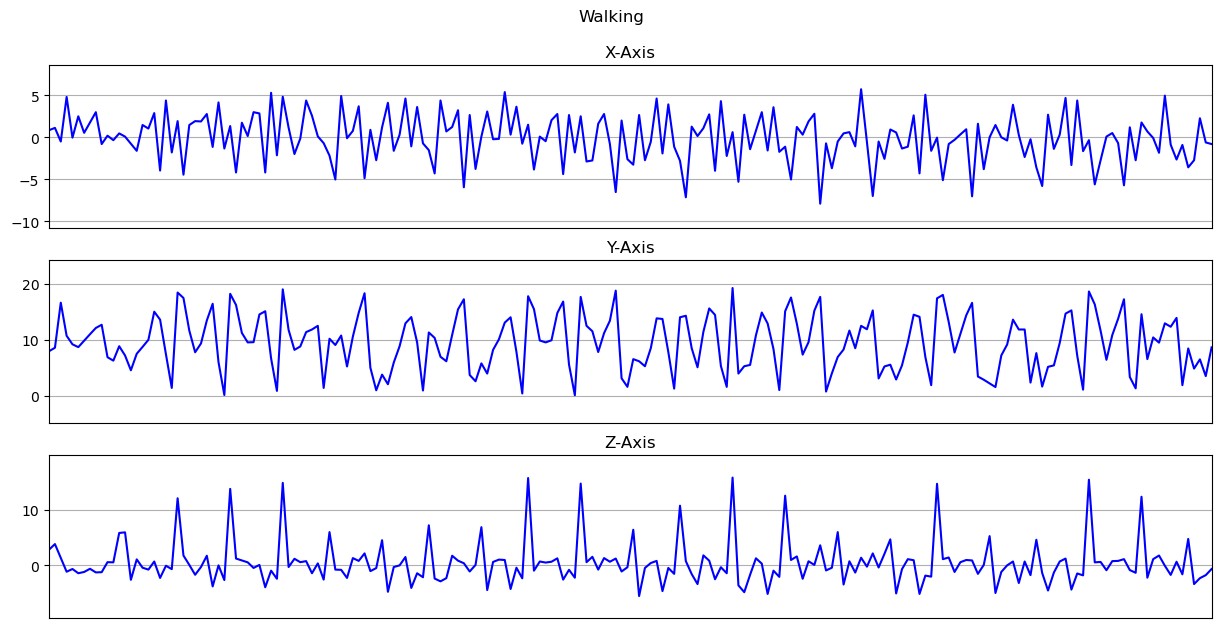

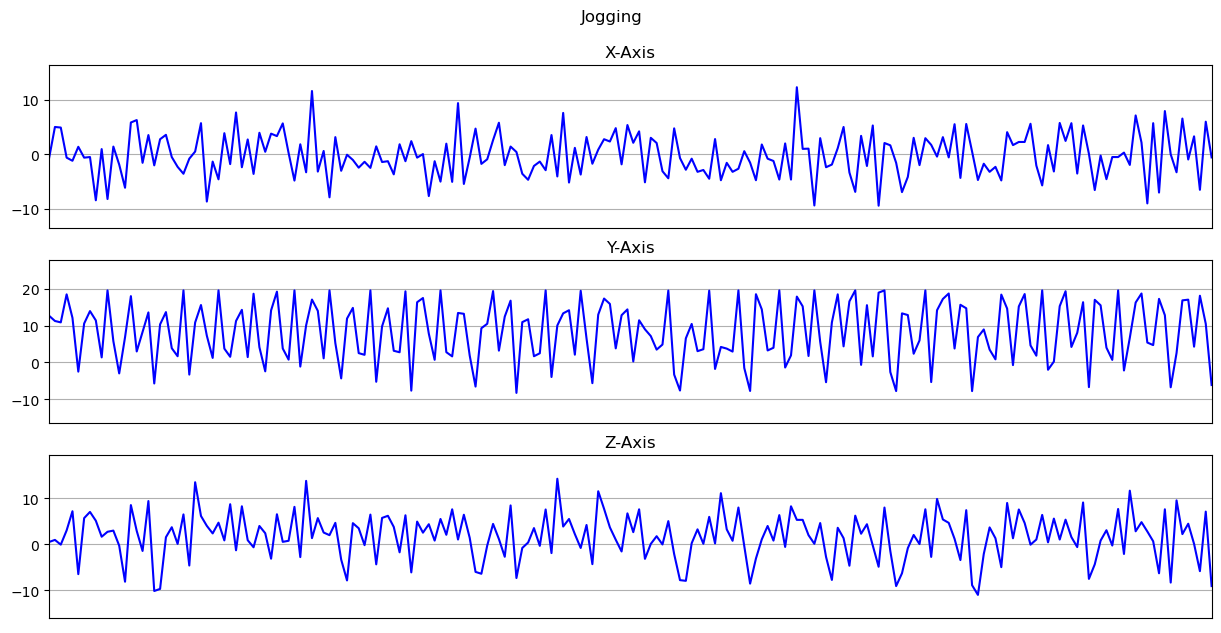

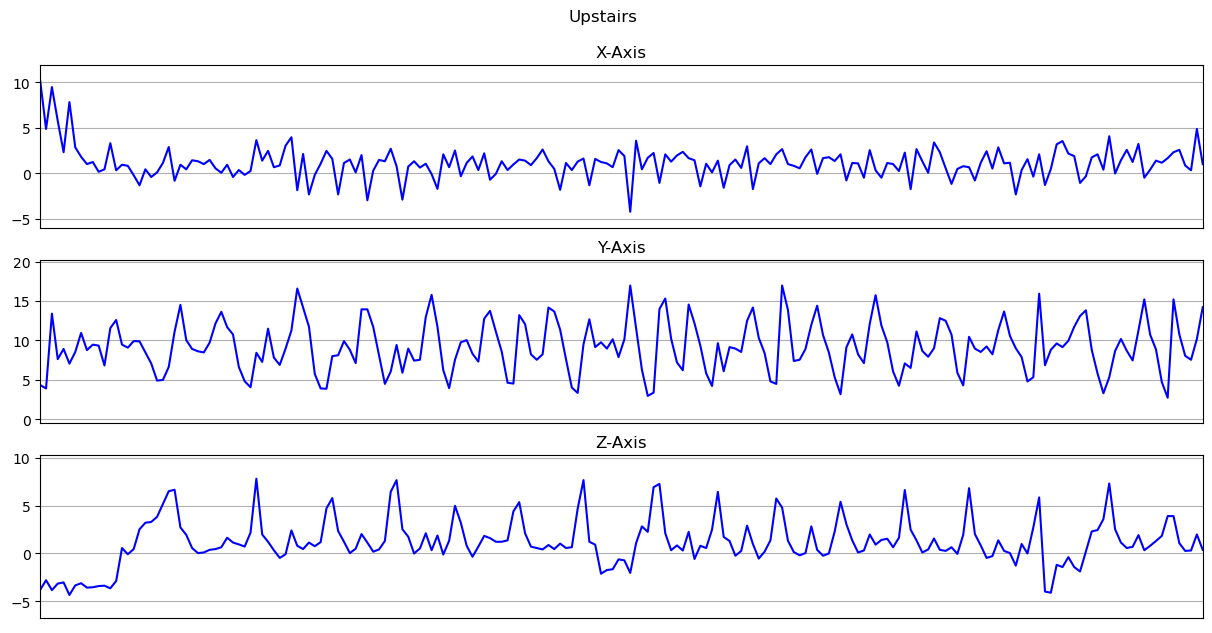

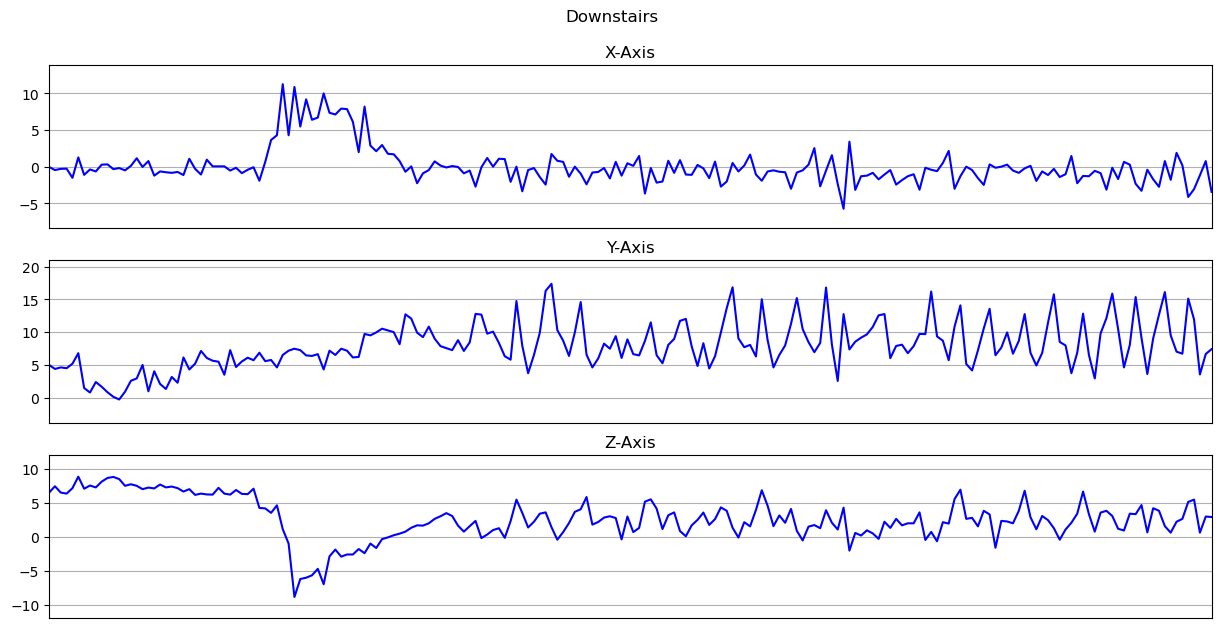

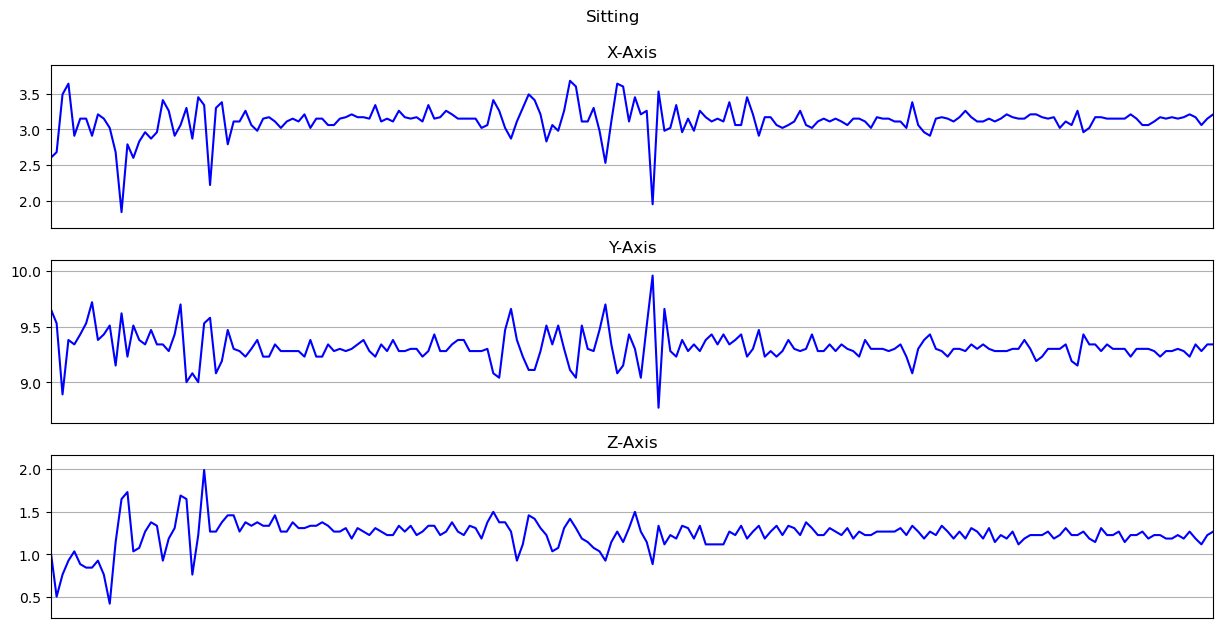

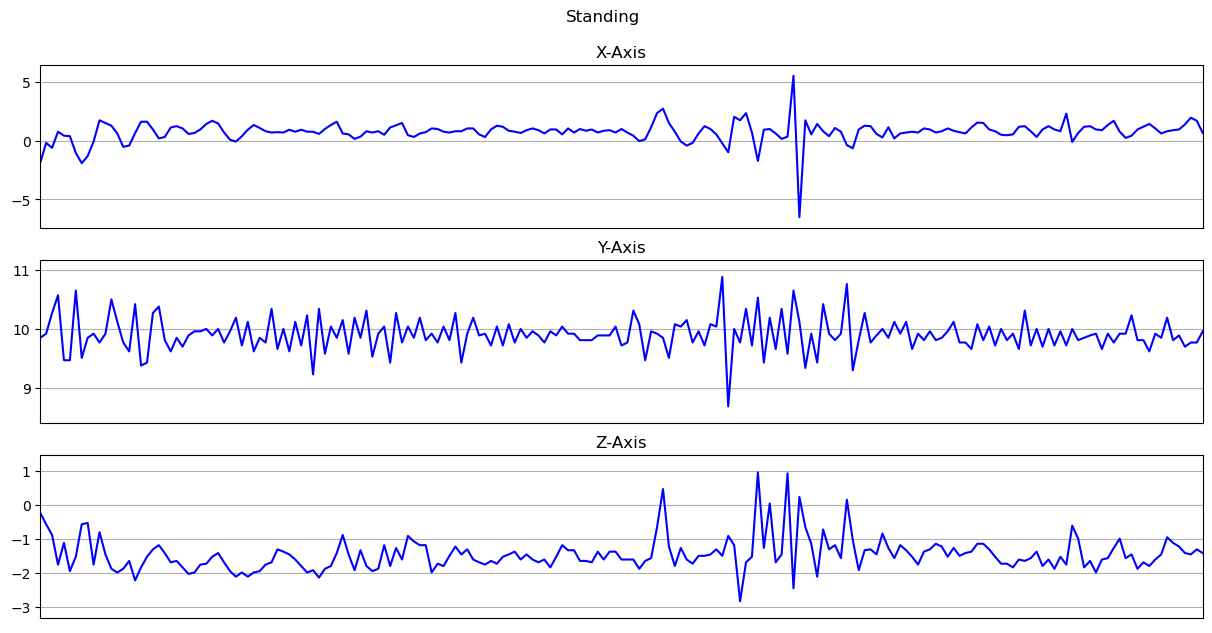

In [6]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
    plot_axis(ax0, data['time'], data['x'], 'X-Axis')
    plot_axis(ax1, data['time'], data['y'], 'Y-Axis')
    plot_axis(ax2, data['time'], data['z'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'b')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in activities:
    data_for_plot = data[(data['activity'] == activity)][:Fs*10]
    plot_activity(activity, data_for_plot)

Here the WISDM dataset has an un-equal nuber of values is each label. Hence we need to balance the dataset, otherwise their is a possibility of overfitting for certain labels or low accuracy for certain labels.

###  Balancing the Dataset

As observed "Walking" has the most values, whereas the label "Standing" has the least

In [7]:
df = data.drop(['user', 'time'], axis = 1).copy()
df['activity'].value_counts()

Walking       137375
Jogging       129392
Upstairs       35137
Downstairs     33358
Sitting         4599
Standing        3555
Name: activity, dtype: int64

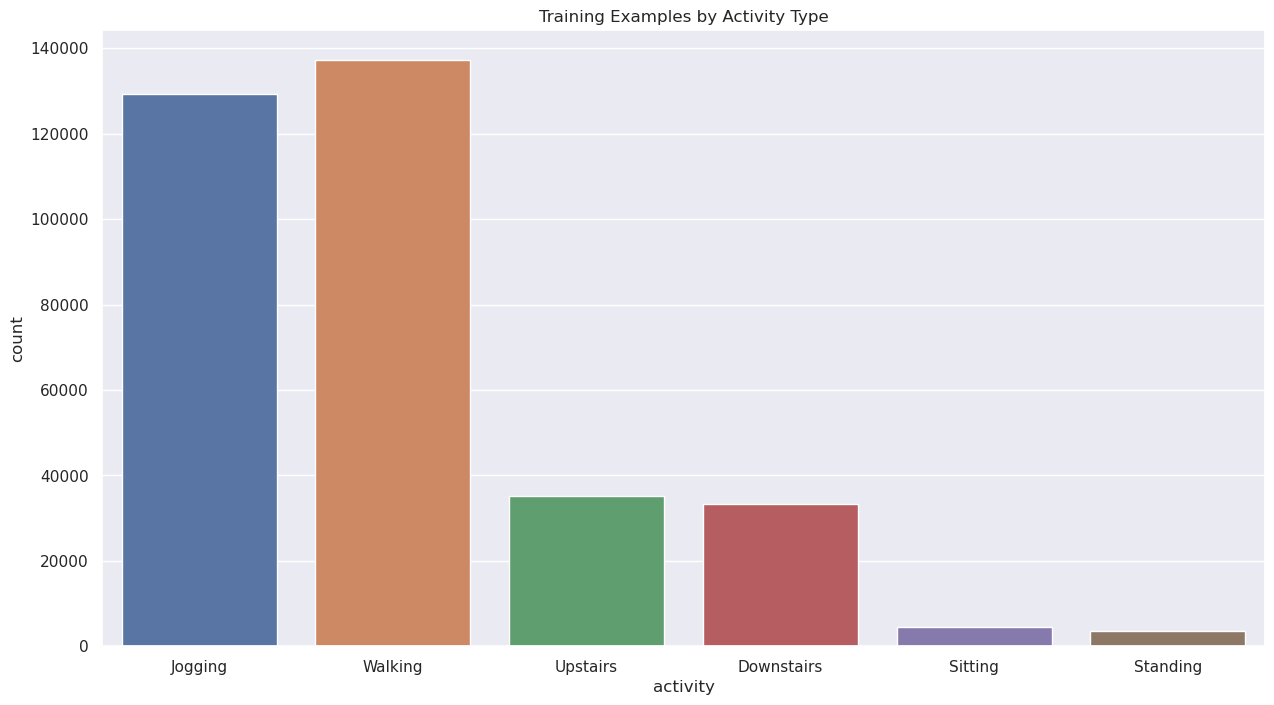

In [8]:
# Analyzing Class Label Distribution
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x = 'activity', data = df)
plt.title('Training Examples by Activity Type')
plt.show()

Since "Standing" has the least quantity of data, we have taken it as a reference for balancing 

In [9]:
Walking = df[df['activity'] == 'Walking'].head(3555).copy()
Jogging = df[df['activity'] == 'Jogging'].head(3555).copy()
Upstairs = df[df['activity'] == 'Upstairs'].head(3555).copy()
Downstairs = df[df['activity'] == 'Downstairs'].head(3555).copy()
Sitting = df[df['activity'] == 'Sitting'].head(3555).copy()
Standing = df[df['activity'] == 'Standing'].copy()

In [10]:
balanced_data = pd.DataFrame()
balanced_data = balanced_data.append([Walking, Jogging, Upstairs, Downstairs, Sitting, Standing])
balanced_data.shape

(21330, 4)

In [11]:
# Displaying the balanced data
print('Activity Count:',balanced_data['activity'].value_counts())

Activity Count: Walking       3555
Jogging       3555
Upstairs      3555
Downstairs    3555
Sitting       3555
Standing      3555
Name: activity, dtype: int64


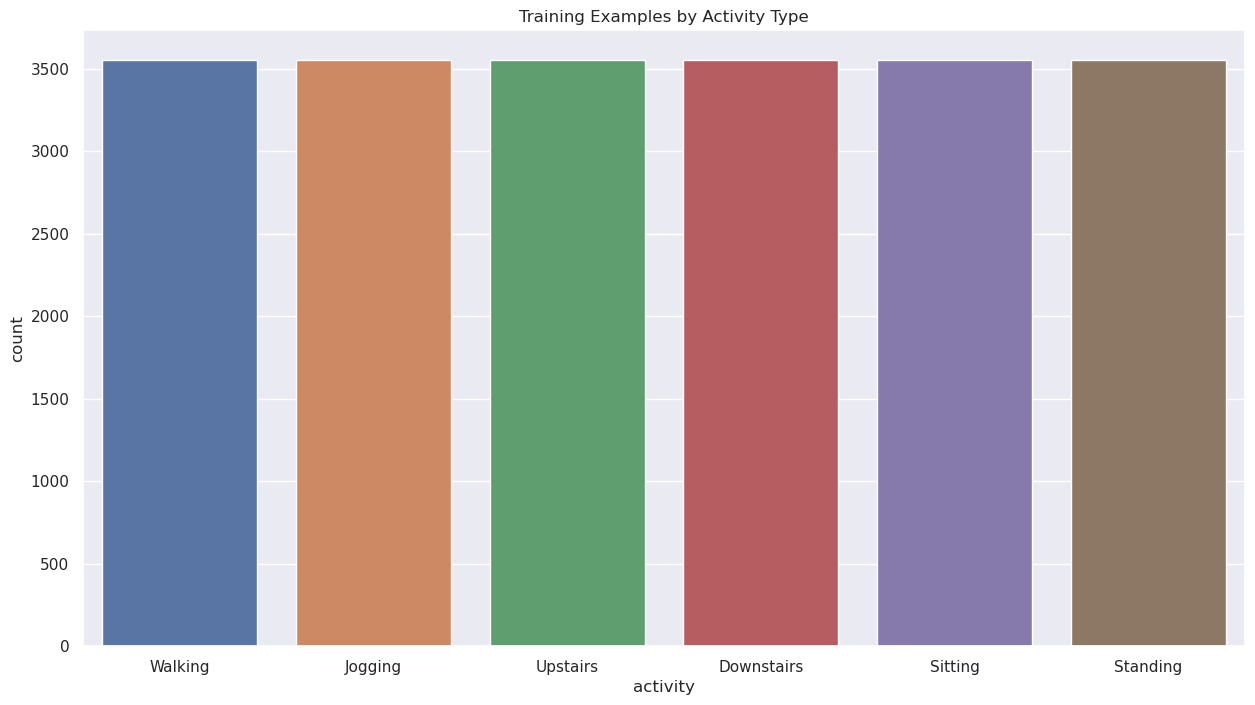

In [12]:
# Analyzing Class Label Distribution
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x = 'activity', data = balanced_data)
plt.title('Training Examples by Activity Type')
plt.show()

In [13]:
# Encoding the Data with suitable labels
label = LabelEncoder()
balanced_data['label'] = label.fit_transform(balanced_data['activity'])
balanced_data.head()

,activity,x,y,z,label
597,Walking,0.844462,8.008764,2.792171,5
598,Walking,1.116869,8.621680,3.786457,5
599,Walking,-0.503953,16.657684,1.307553,5
600,Walking,4.794363,10.760075,-1.184970,5
601,Walking,-0.040861,9.234595,-0.694638,5


### Standardizing the Dataset

In [14]:
X = balanced_data[['x','y','z']]
y = balanced_data['label']

scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['x', 'y', 'z'])
scaled_X['label'] = y.values

scaled_X

,x,y,z,label
0,0.000503,-0.099190,0.337933,5
1,0.073590,0.020386,0.633446,5
2,-0.361275,1.588160,-0.103312,5
3,1.060258,0.437573,-0.844119,5
4,-0.237028,0.139962,-0.698386,5
...,...,...,...,...
21325,-0.470217,0.178084,0.261019,3
21326,-0.542658,0.193692,0.248875,3
21327,-0.628514,0.197593,0.261019,3
21328,-0.781444,0.049322,0.155768,3


In [15]:
Fs = 20
frame_size = Fs*4 # 80
hop_size = Fs*2 # 40

def get_frames(df, frame_size, hop_size):

    N_FEATURES = 3

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x = df['x'].values[i: i + frame_size]
        y = df['y'].values[i: i + frame_size]
        z = df['z'].values[i: i + frame_size]
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df['label'][i: i + frame_size])[0][0]
        frames.append([x, y, z])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

In [16]:
scaled_X = scaled_X.replace([np.inf, -np.inf], np.nan)
scaled_X = scaled_X.dropna()
scaled_X = scaled_X.reset_index()
X, y = get_frames(scaled_X, frame_size, hop_size)
X.shape, y.shape

((532, 80, 3), (532,))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)
X_train.shape, X_test.shape

((425, 80, 3), (107, 80, 3))

In [18]:
X_train[0].shape, X_test[0].shape

((80, 3), (80, 3))

In [19]:
X_train = X_train.reshape(425, 80, 3, 1)
X_test = X_test.reshape(107, 80, 3, 1)
X_train[0].shape, X_test[0].shape

((80, 3, 1), (80, 3, 1))

<h2><b>2D CNN Model</h2></b>

In [20]:
model = Sequential()
model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = X_train[0].shape))
model.add(Dropout(0.1))

model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))


In [21]:
opt_adam = tf.keras.optimizers.Adam(learning_rate = 0.001)

In [22]:
model.compile(optimizer=opt_adam, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [23]:
# Traning the Model
history = model.fit(X_train, y_train, epochs = 100, validation_data= (X_test, y_test), verbose=1)

Epoch 1/100
14/14 [==============================] - 2s 29ms/step - loss: 1.6083 - accuracy: 0.2894 - val_loss: 1.2601 - val_accuracy: 0.4766
Epoch 2/100
14/14 [==============================] - 0s 12ms/step - loss: 1.1599 - accuracy: 0.5647 - val_loss: 0.8597 - val_accuracy: 0.7944
Epoch 3/100
14/14 [==============================] - 0s 13ms/step - loss: 0.8618 - accuracy: 0.6918 - val_loss: 0.5862 - val_accuracy: 0.8692
Epoch 4/100
14/14 [==============================] - 0s 12ms/step - loss: 0.6879 - accuracy: 0.7553 - val_loss: 0.4775 - val_accuracy: 0.8318
Epoch 5/100
14/14 [==============================] - 0s 12ms/step - loss: 0.5419 - accuracy: 0.8188 - val_loss: 0.3908 - val_accuracy: 0.8692
Epoch 6/100
14/14 [==============================] - 0s 12ms/step - loss: 0.4749 - accuracy: 0.8165 - val_loss: 0.3203 - val_accuracy: 0.8879
Epoch 7/100
14/14 [==============================] - 0s 12ms/step - loss: 0.4204 - accuracy: 0.8400 - val_loss: 0.3216 - val_accuracy: 0.8505
Epoch 

In [24]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

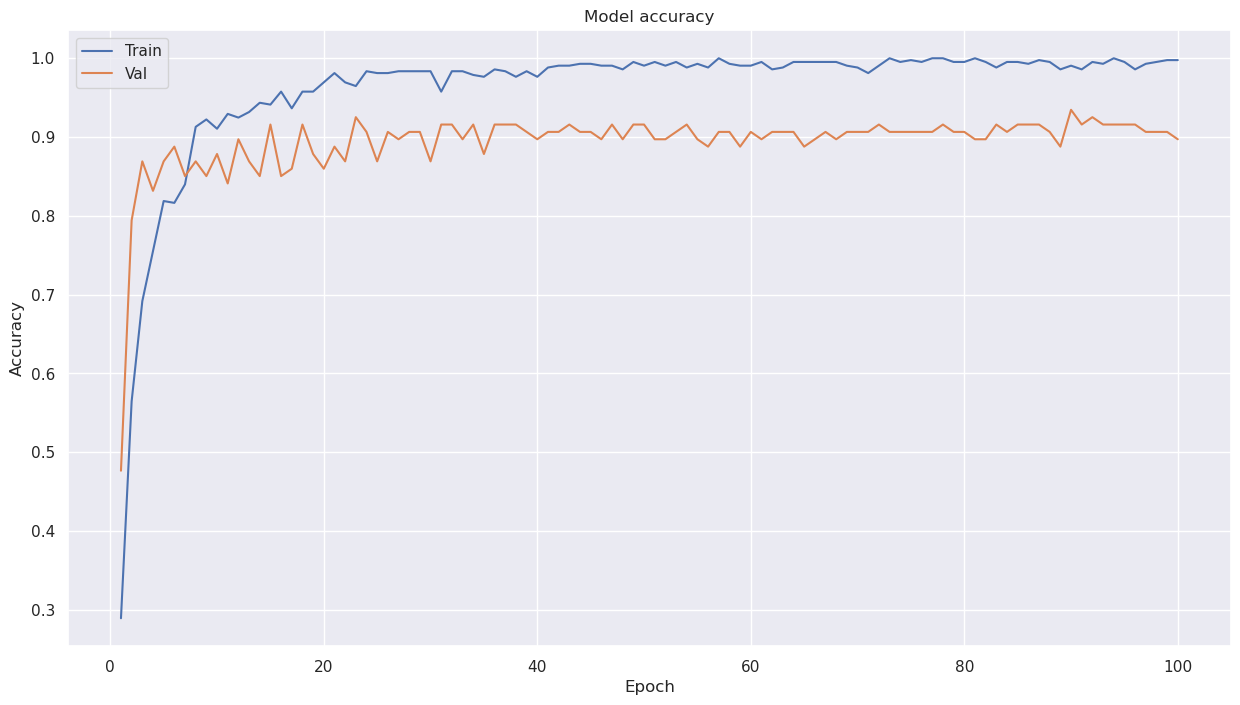

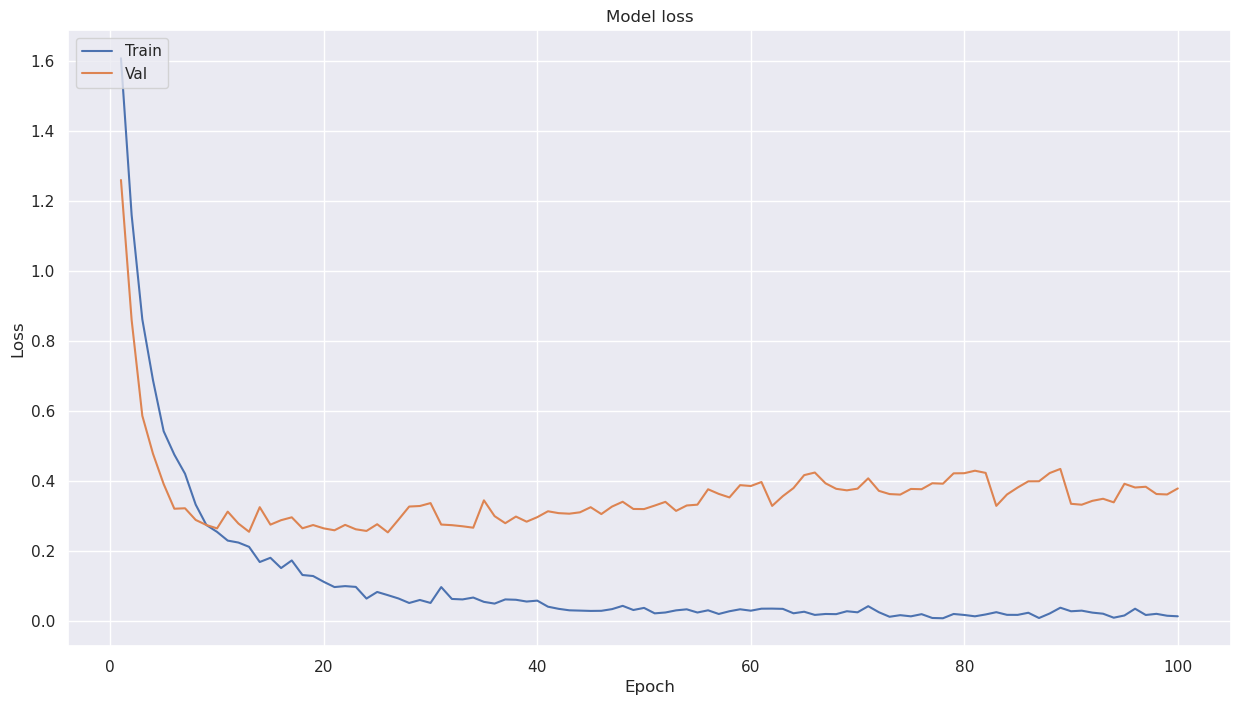

In [25]:
plot_learningCurve(history, 100)

<h2><b>Results</b></h2>

###Confusion Matrix

4/4 [==============================] - 0s 3ms/step


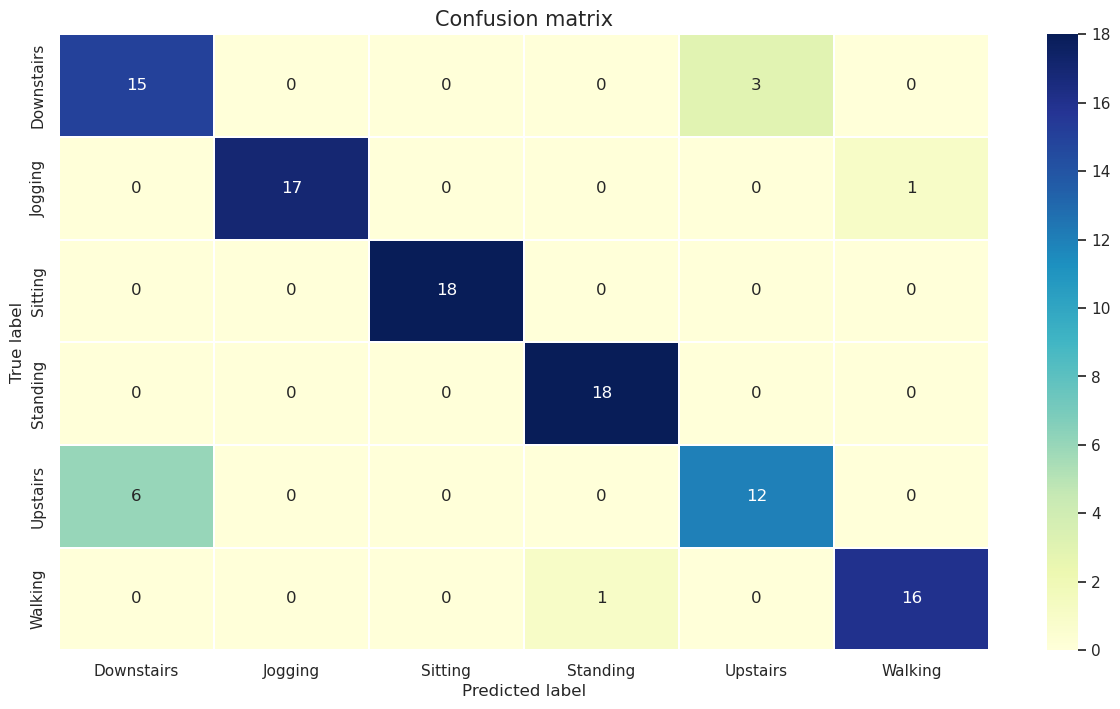

In [26]:
class_labels = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
predict_x=model.predict(X_test) 
# y_pred = model.predict_classes(X_test)
y_pred=np.argmax(predict_x,axis=1)
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, xticklabels = class_labels, yticklabels = class_labels, annot = True, linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
#plot_confusion_matrix(conf_mat=mat, classes = label.classes_, show_normed=True, figsize=(7,7))


### Classification Report

In [27]:
results = precision_recall_fscore_support(y_test, y_pred, average='macro')

In [28]:
print("The Testing Accuracy of the model:            {} %".format(accuracy_score(y_test, y_pred)*100))
print(f'\nThe Precision of the given 2D CNN model is:   {results[0]*100} %')
print(f'\nThe Recall of the given 2D CNN model is:      {results[1]*100} %')
print(f'\nThe F1-score of the given 2D CNN model is:    {results[2]*100} %')

The Testing Accuracy of the model:            89.7196261682243 %

The Precision of the given 2D CNN model is:   90.04717676544303 %

The Recall of the given 2D CNN model is:      89.760348583878 %

The F1-score of the given 2D CNN model is:    89.70135852488794 %


In [29]:
model.save('model.h5')

In [36]:


# Step 1: Load the saved model
model = tf.keras.models.load_model('model.h5')

# Step 2: Load the new TXT data
new_data = np.loadtxt('/kaggle/input/walking/walking.txt')

# Step 3: Preprocess the new data
new_data = new_data.reshape(-1, 80, 3, 1)  # reshape the data to (samples, time steps, features, channels)
new_data = scaler.transform(new_data)

# Step 4: Use the loaded model to predict the output
predictions = model.predict(new_data)


ValueError: cannot reshape array of size 9864 into shape (80,3,1)

<h2><b>Effect of Optimizers</h2></b>